# Code development: pytest and pip

*Davide Gerosa (Milano-Bicocca)*

**Sources**: 
 - Michael Zingale at Stony Brook University: https://sbu-python-class.github.io
 - Googling around (a lot)
 - My own research.


Plan for today. I'd like to showcase three more things you might need in your research in computational physics.

- **Part 1**. Package and share your code
- **Part 2**. Testing done right
- **Part 3**. Find the bottleneck

# Part 1. Package and share your code

In [5]:
import os, sys

So far, we've been writing our code all in Jupyter.  But when it comes
time to write code that we want to reuse, we want to put it into a
standalone `*.py` file.

Then we can load it on in python (or Jupyter) and use the capabilities
it provides or make it a standalone program that can be run from the
command line.

Jupyter is great for interactive explorations and sharing your workflow with others
in a self-contained way.  But if there is an operation that you do over and over,
you should put it into a separate module that you import.  That way you only need to
maintain and debug a single instance of the function, and all your workflows can reuse it.


## Editors

Use your preferred editors. Some popular ones include:

* VS Code: https://code.visualstudio.com/
* spyder: https://www.spyder-ide.org/
* emacs / vi

Rest in peace [Atom](https://github.blog/2022-06-08-sunsetting-atom/), you were the best.


## Standalone module

Here's a very simple module (lets call it `hello.py`):

```python
def hello():
    print("hello")

if __name__ == "__main__":
    hello()
```

There are two ways we can use this.

* Inside of python (or jupyter), we can do:

  ```python
  import hello
  hello.hello()
  ```

* From the command line, we can do:

  ```python
  python hello.py
  ```

Additionally, on a Unix system, we can add:

```python
#!/usr/bin/env python3
```

to the top and then mark the file as executable, via:

```bash
chmod a+x hello.py
```

allowing us to execute it simply as:

```bash
./hello.py
```

Here we see how the `__name__` variable is treated by python:

* If we import our module into python, then `__name__` is set to the module name
* If we run the module from the command line, then `__name__` is set to `__main__`


## Changing module contents

If we make changes to our module file, then we need to re-import it.  This can be done as:

```python
import importlib
example = importlib.reload(example)
```


# Command line arguments

For standalone programs, we often want to have our program take
command line arguments that affect the runtime behavior of our
program.  There are a variety of mechanisms to do this in python, but
the best option is the [argparse
module](https://docs.python.org/3/library/argparse.html).

Here's an example of using `argparse` to take a variety of options:


In [6]:
# %load argparse_example.py


```python
#!/usr/bin/env python3

# to get usage: use -h
import argparse


def setup_args():

    # simple example of argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("-a", help="the -a option", action="store_true")
    parser.add_argument("-b", help="-b takes a number", type=int, default=0)
    parser.add_argument("-c", help="-c takes a string", type=str, default=None)
    parser.add_argument("--darg", help="the --darg option", action="store_true")
    parser.add_argument("--earg", help="--earg takes a string", type=str, metavar="test",
                        default="example string")

    # extra arguments (positional)
    parser.add_argument("extras", metavar="extra", type=str, nargs="*",
                        help="optional positional arguments")

    return parser.parse_args()


if __name__ == "__main__":

    args = setup_args()


    if args.a:
        print("-a set")
    print(f"-b = {args.b}")
    print(f"-c = {args.c}")
    if args.darg:
        print("--dargs set")
    print(f"--earg value = {args.earg}")

    print(" ")
    print("extra positional arguments: ")
    if len(args.extras) > 0:
        for e in args.extras:
            print(e)
```

A nice feature of `argparse` is that it automatically generates help for us.  If
we place the above code in `argparse_example.py` then we can do:

In [7]:
os.system('python argparse_example.py --help');

usage: argparse_example.py [-h] [-a] [-b B] [-c C] [--darg] [--earg test]
                           [extra ...]

positional arguments:
  extra        optional positional arguments

options:
  -h, --help   show this help message and exit
  -a           the -a option
  -b B         -b takes a number
  -c C         -c takes a string
  --darg       the --darg option
  --earg test  --earg takes a string


# Paths

How does python find modules?  It has a [search order](https://docs.python.org/3/tutorial/modules.html#the-module-search-path):

* current directory

* `PYTHONPATH` environment variable (this follows the same format as
  the shell `PATH` environment variable). This variable can be empty.

* System-wide python installation default path (usually has a
  `site-packages` directory)

We can look at the path via ``sys.path``.  On my machine I get:

In [14]:
sys.path

['/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python311.zip',
 '/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11',
 '/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload',
 '',
 '/Users/dgerosa/box/lib/python3.11/site-packages']

My PYTHONPATH is empty...

In [15]:
os.system('echo $PYTHONPATH')

0

You can add things explicitly to my the `PYTHONPATH` shell variable.

Using `PYTHONPATH` to quickly add a module to your search path is an easy hack,
but if you are developing a library that will be used by others, it is better
to make the modules installable to the system search paths.  This is where
_packaging_ comes into play.

# Packaging



Let's look at the structure of creating an installable python package.
The python packaging system is constantly evolving, and the current recommendations
of tools is list here: https://packaging.python.org/en/latest/guides/tool-recommendations/

Eventually, you'll want people to do  `pip install myawesomepackage`. One thing at the time...


## Our example

We'll work on an example that builds on the Mandelbrot set exercise
from the matplotlib session.  Our example is hosted here:

https://github.com/dgerosa/scientificcomputing_bicocca_2025/tree/main/lectures/modulescicompclass

The directory structure appears as:

```
modulescicompclass
├── modulescicompclass
│   ├── __init__.py
│   └── mandel.py
└── README.md
└── setup.py
```

This is a rather common way of structuring a project:

* The top-level `modulescicompclass` directory is not part of the python
  package, but instead is where the source control (e.g. git) begins,
  and also hosts setup files that are used for installation

* `modulescicompclass/modulescicompclass` is the actual python module that we will load. To make python recognize this as a module, we need an `__init__.py` file there --- it can be completely empty.
   
   
* The actual `*.py` files that make up our module are in `modulescicompclass/modulescicompclass`

Right now, this package does not appear in our python search path, so
the only way to load it is to work in the top-level `mymodule/`
directory (that's because the current directory is *always* in the path).

## setuptools

The current python package recommendations are:

* Installation:

  * `pip` to install packages from PyPI
  * `conda` for distributing cross-platform software stacks

* Packaging tools:

  * `setuptools` to create source distributions
  * `build` for binary distributions
  * `twine` to upload to PyPI

Let's look at how to use [`setuptools`](https://setuptools.pypa.io/en/latest/index.html) to package our library.  See the
packaging guidelines here:
https://packaging.python.org/en/latest/guides/distributing-packages-using-setuptools/

The main thing we need to do is create a `setup.py` that describes our
package and its requirements:

Here's a first `setup.py`:

```python
from setuptools import setup, find_packages

setup(name='modulescicompclass',
      description='test module for the SciComp class',
      url='https://github.com/dgerosa',
      author='Davide Gerosa',
      author_email='davide.gerosa@unimib.it',
      license='MIT',
      version='0.0.1',
      packages=find_packages(),
      install_requires=['numpy', 'matplotlib'])
```


The packaging ecosystem is always evolving (too quickly if you ask me...).  There are 2 special config files that can help customize the package and contain the defaults for other tools: `setup.cfg` and
`pyproject.toml`.  See:

* [Configuring setuptools using `setup.cfg` files](https://setuptools.pypa.io/en/latest/userguide/declarative_config.html)

* [Configuring setuptools using `pyproject.toml` files](https://setuptools.pypa.io/en/latest/userguide/pyproject_config.html)
```


## Installing

We can use setup in a variety of ways.  Two useful ways are:

* Install:

  `python setup.py install`

  This will copy the source files into your install location (likely
  `~/.local/...`) putting them into your python search path.  Then you
  can use this package from anywhere.

* Development mode (https://setuptools.pypa.io/en/latest/userguide/development_mode.html):

  `python setup.py develop`

  This doesn't actually install anything in your user- or site-wide
  install location, but instead it creates a special link in that
  install directory back to your actual project code.

  This allows you to continue to develop the package without needed to
  re-install each time you change the source.

  You can uninstall via:

  `pip uninstall modulescicompclass`

The above put the package in the system-wide path. Should be ok for your laptop, but if you're on a cluster where you don't have admin privileges use the `--user` flag.


## Using our module

Once the module is installed, we can use it from any directory.  For example, if we do:

In [16]:
import modulescicompclass

In [17]:
import modulescicompclass
print(modulescicompclass.__file__)

/Users/dgerosa/box/lib/python3.11/site-packages/modulescicompclass/__init__.py


In [18]:
import numpy
print(numpy.__file__)

/Users/dgerosa/box/lib/python3.11/site-packages/numpy/__init__.py


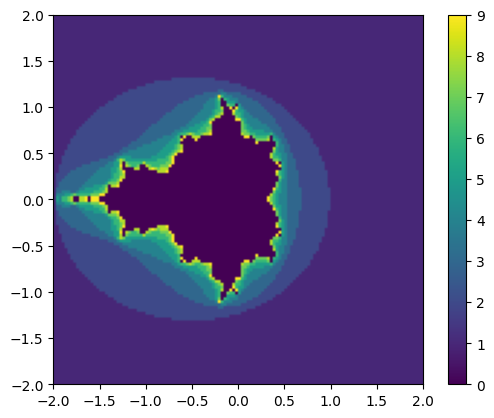

In [19]:
fig = modulescicompclass.mandelbrot(128)

## pip Deployment 

Making your code pip-installable is now trivial. The one thing left to do is uploading your code to https://pypi.org/ which is where pip looks for information. 

Pypi (Python Package Index) is beautiful because it's open and free, everybody can make their code available! (but that's also free territory for [frauds](https://www.welivesecurity.com/en/eset-research/pernicious-potpourri-python-packages-pypi/), so careful with what you install).


You need to create an account on pypi and generate an API token. Instructions [here](https://packaging.python.org/en/latest/tutorials/packaging-projects/).

This involves writing a `.pypirc` file in your home directory

```
[distutils]
index-servers =
    pypi
    testpypi

[pypi]
username = __token__
password: YOUR TOKEN GOES HERE

[testpypi]
username = __token__
password: YOUR TOKEN GOES HERE
```


 Then create the distribution bundle with 

```python setup.py sdist``` to create the distribution bundle

Pypi has a test server https://test.pypi.org/ where you can try things out before going to the real pip repository (don't want to mess things up...). Upload with


```twine upload --repository testpypi dist/* #for the test server```

When you're confident everything works

```twine upload dist/* #for the real pip```

and you're done! Everybody will be able to pip-install and use your code. 

Here we are: https://test.pypi.org/project/modulescicompclass/

Anyone can now install this code!


```pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple modulescicompclass```

If you upload it to the real pip than this becomes

```pip install modulescicompclass```



For a complete example from my research have a look at https://github.com/dgerosa/precession which is indeed pip installable. 



**Important** 
- Modules names on pip are unique. When you upload a package for the first time, that name belongs to you and you only. For this reason, when trying to run these instructions you won't be able to upload a package called `modulescicompclass` because that name is mine now. Just change the name.
- Versioning is also unique. You *cannot* replace a package on pip, only release a newer code bumping the version up.  



<div class="alert alert-block alert-warning">

Let me say here that producing good, well documented, and reusable code is *crucial* for being influential in modern research. No point understanding a beautiful piece of physics if nobody else can use it!  
    
</div>



# Tools to Make Your Life Easier

## Version control

Put your project under git version control. Just do it. 


## Code checkers

There are a number of tools that help check code for formatting and
syntax errors that are quite useful for developers.  Many projects
automatically enforce these tools on changes submitted to github.

Many editors have plugins that can automatically run these tools
as your write your code.

* [flake8](https://flake8.pycqa.org/en/latest/)

  `flake8` is a checker for [PEP 8](https://peps.python.org/pep-0008/)
  style conformance.  You can turn off checks that you don't like
  via a [`.flake8`
  file](https://flake8.pycqa.org/en/latest/user/configuration.html#configuration-locations).

* [pylint](https://pypi.org/project/pylint/)

  `pylint` is a static code analyzer.  It can find errors and also suggest improvements
  to your code.  You can [generate a configuration file](https://pylint.readthedocs.io/en/latest/user_guide/configuration/index.html)
  to customize its behavior (or add a section to `pyproject.toml`).

* [black](https://pypi.org/project/black/)

  `black` is an _uncompromising code formatted_.  It will automatically rewrite your code
  based on PEP-8 style.

* [pyupgrade](https://github.com/asottile/pyupgrade)

  `pyupgrade` will upgrade source to a later python standard, making
  use of new features where available.  For instance, you can run as:

  ```
  pyupgrade --py39-plus file.py
  ```

  to update to python 3.9 support.

* [isort](https://pycqa.github.io/isort/)

  `isort` simply sorts the module imports at the top of your modules,
  grouping the standard python ones together followed by
  package-specific ones.


# Part 2. Unit testing with pytest

Testing is an integral part of the software development process.  We want to catch
mistakes early, before the go on to affect our results.

## Types of testing

There are a lot of different types of software testing that exist.
Most commonly, for scientific codes, we hear about:

* Unit testing : Tests that a single function does what it was designed to do

* Integration testing : Tests whether the individual pieces work together as intended.
  Sometimes done one piece at a time (iteratively)

* Regression testing : Checks whether changes have changed answers

* Verification & Validation (from the science perspective)

  * Verification: are we solving the equations correctly?

  * Validation: are we solving the correct equations?

## Automating testing

The best testing is automated.  Github provides a *continuous integration* service that can
be run on pull requests.  You write a short definition (a Github workflow) that tells Github
how to run your tests and then any time there is a change, the tests are run.

## Unit testing

* When to write tests?

  * Some people advocate writing a unit test for a specification
    before you write the functions they will test

    * This is called Test-driven development (TDD):
      https://en.wikipedia.org/wiki/Test-driven_development

  * This helps you understand the interface, return values,
    side-effects, etc. of what you intend to write

* Often we already have code, so we can start by writing tests to
  cover some core functionality

  * Add new tests when you encounter a bug, precisely to ensure that
    this bug doesn't arise again

* Tests should be short

  * You want to be able to run them frequently





# pytest

`pytest` is a unit testing framework for python code.

Basic elements:

* Discoverability: it will find the tests

* Automation

* Fixtures (setup and teardown)

## Installing

You can install `pytest` for a single user as:

```
pip install pytest
```

This should put `pytest` in your search path, likely in `~/.local/bin`.

If you want to generate coverage reports, you should also install `pytest-cov`:

```
pip install pytest-cov
```

## Test discovery

Adhering to these naming conventions will ensure that your tests are automatically found:

* File names should start or end with “test”:

  * `test_example.py`
  * `example_test.py`

* For tests in a class, the class name should begin with `Test`

  * e.g., `TestExample`
  * There should be no `__init__()`

* Test method / function names should start with `test_`

  * e.g., `test_example()`

## Assertions

Tests use assertions (via python’s `assert` statement) to check behavior at runtime

* https://docs.python.org/3/reference/simple_stmts.html#assert 

* Basic usage: `assert expression`

  * Raises `AssertionError` if expression is not true

  * e.g., `assert 1 == 0` will fail with an exception

## Simple pytest example

Create a file named `multiply_test.py` with the following content:

```python
def multiply(a, b):
    return a*b

def test_multiply():
    assert multiply(4, 6) == 24

def test_multiply2():
    assert multiply(5, 6) == 2
```

then we can run the tests as:

```
pytest -v
```

and we get the output:

```
============================= test session starts ==============================
platform linux -- Python 3.11.3, pytest-7.2.2, pluggy-1.0.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /home/zingale/temp/pytest
plugins: anyio-3.6.2
collected 2 items                                                              

test_simple.py::test_multiply PASSED                                     [ 50%]
test_simple.py::test_multiply2 FAILED                                    [100%]

=================================== FAILURES ===================================
________________________________ test_multiply2 ________________________________

    def test_multiply2():
>       assert multiply(5, 6) == 2
E       assert 30 == 2
E        +  where 30 = multiply(5, 6)

test_simple.py:8: AssertionError
=========================== short test summary info ============================
FAILED test_simple.py::test_multiply2 - assert 30 == 2
========================= 1 failed, 1 passed in 0.04s ==========================
```

this is telling us that one of our tests has failed.


# More pytest

Unit tests sometimes require some setup to be done before the test is run.  Fixtures
provide this capability.

pytest provides `setup` and `teardown` functions/methods for tests --
see https://docs.pytest.org/en/6.2.x/fixture.html for more details

Note:  By default, pytest will capture stdout and only show it on failures.  If you want
to always show stdout, add the `-s` flag.


## Example class

It is common to use a class to organize a set of related unit tests.  This is
not a full-fledged class -- it simply helps to organize data.  In particular,
there is no constructor, `__init__()`.  See https://stackoverflow.com/questions/21430900/py-test-skips-test-class-if-constructor-is-defined

We'll look at an example with a NumPy array

* We always want the array to exist for our tests, so we'll use
  fixtures (in particular `setup_method()`) to create the array

* Using a class means that we can access the array created in setup from our class.

* We'll use numpy's own assertion functions: https://numpy.org/doc/stable/reference/routines.testing.html


Here's an example:

```python
# a test class is useful to hold data that we might want setup
# for every test.

import numpy as np
from numpy.testing import assert_array_equal

class TestClassExample:

    @classmethod
    def setup_class(cls):
        """ this is run once for each class, before any tests """
        pass

    @classmethod
    def teardown_class(cls):
        """ this is run once for each class, after all tests """
        pass

    def setup_method(self):
        """ this is run before each of the test methods """
        self.a = np.arange(24).reshape(6, 4)

    def teardown_method(self):
        """ this is run after each of the test methods """
        pass

    def test_max(self):
        assert self.a.max() == 23

    def test_flat(self):
        assert_array_equal(self.a.flat, np.arange(24))
```


Here we see the [`@classmethod` decorator](https://docs.python.org/3/library/functions.html#classmethod).
This means that the function receives the class itself as the first argument rather then an instance,
e.g., `self`.


Put this into a file called `test_class.py` and then we can run as:

```
pytest -v
```



## Modern workflow

Modern code tested is collaborative and automated. Say you found a bug in numpy and want to fix it. You can only pull request to their git repo only if your patch passes a whole suite of tests.

That's for big things, but I argue having some basic unit tests is important for every code, even your little PhD project (and well... if you end up having a pull request merged into numpy, that should go straight into your CV!!!)


## Other types of tests

Unit tests are only one form of testing - they test a function in
isolation of others.  Sometimes we need to test everything working together.
For scientific codes, regression testing is often used.  The basic workflow
is:

* Start with the project working in a way you are happy with

* Store the output of one (or more) runs as a _benchmark_.

* Each time you make changes, run the code and compare the new output
  to the stored benchmark.

  * If there are no differences, then your changes are likely good
    (but there is always the case of some feature not being tested).

  * If there are differences, then either you introduced a bug, in which
    case you should fix it, or you fixed a bug, in which case you should
    update the benchmarks.


# Part 3: profiling


Profiling is the art of figuring out where you're wasting time. If your code is too slow, it's very very rare that the entire code is slow. Often you have one or a few bottlenecks, and rewriting those little pieces will make your life beautiful again. You could then try to make a smarter use on numpy, jit them with Numba, or make them run in parallel, as appropriate.

The standard python profiling tool is called [cProfile](https://docs.python.org/3/library/profile.html).

This is a random example:

In [20]:

from scipy.optimize import minimize


def myfunc():
    # c.f. https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    func = lambda x: (x[0] - 1) ** 2 + (x[1] - 2.5) ** 2
    x0 = (2, 0)

    constraints = (
        {"type": "ineq", "fun": lambda x: x[0] - 2 * x[1] + 2},
        {"type": "ineq", "fun": lambda x: -x[0] - 2 * x[1] + 6},
        {"type": "ineq", "fun": lambda x: -x[0] + 2 * x[1] + 2},
    )

    bounds = ((0, None), (0, None))

    result = minimize(func, x0, method="SLSQP", bounds=bounds, constraints=constraints)
    print(f"result:\n{result}")
    print(f"best fit parameters: {result.x}")

In [21]:
myfunc()

result:
     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 0.800000001192098
           x: [ 1.400e+00  1.700e+00]
         nit: 3
         jac: [ 8.000e-01 -1.600e+00]
        nfev: 10
        njev: 3
 multipliers: [ 8.000e-01  0.000e+00  0.000e+00]
best fit parameters: [1.4 1.7]


This will tell us exactly where the time goes... 


In [22]:
import cProfile 
cProfile.run('myfunc()', sort='cumtime')

result:
     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 0.800000001192098
           x: [ 1.400e+00  1.700e+00]
         nit: 3
         jac: [ 8.000e-01 -1.600e+00]
        nfev: 10
        njev: 3
 multipliers: [ 8.000e-01  0.000e+00  0.000e+00]
best fit parameters: [1.4 1.7]
         3099 function calls (3080 primitive calls) in 0.011 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.011    0.011 {built-in method builtins.exec}
        1    0.000    0.000    0.011    0.011 <string>:1(<module>)
        1    0.000    0.000    0.011    0.011 3251406122.py:4(myfunc)
        1    0.000    0.000    0.009    0.009 _minimize.py:54(minimize)
        1    0.001    0.001    0.008    0.008 _slsqp_py.py:215(_minimize_slsqp)
       12    0.001    0.000    0.005    0.000 _numdiff.py:278(approx_derivative)
        3    0.000    0.000    0.004    0.001 _

In [23]:
# This is the same but dumps to file

with cProfile.Profile() as pr:
    myfunc()  

pr.dump_stats('example.prof')

result:
     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 0.800000001192098
           x: [ 1.400e+00  1.700e+00]
         nit: 3
         jac: [ 8.000e-01 -1.600e+00]
        nfev: 10
        njev: 3
 multipliers: [ 8.000e-01  0.000e+00  0.000e+00]
best fit parameters: [1.4 1.7]


There's a super nice interface which is called [snakeviz](https://jiffyclub.github.io/snakeviz/). Try this:

```snakeviz example.prof```

(might need to `pip install snakeviz` first of course)

## A complete example from my own research: merging binary black holes

Let's evolve some black-hole binaries from large separations (presumably where they form following stellar collapse) to small separation where they merge and become detectable as gravitational-wave searches.

This is a python module I wrote: https://github.com/dgerosa/precession

The mathematical problem is described here https://arxiv.org/abs/2304.04801
In short, we need to solve some ordinary differential equations with a RHS that contains some elliptic integrals, and in turn some of the parameters of these elliptic integrals are solutions to some (very long!) polynomials.

**Warning**: don't look at the appendices of that paper before getting a good cup of coffee. And if you do, of course those equations are machine-generated. I used Mathematica to compute the equations, and then exported the results to python.

In [24]:
import precession # You need to "pip install precession"
import numpy as np


def blackholes():
    
    N=100
    q=np.random.uniform(0.1,1,N)
    chi1=np.random.uniform(0.1,1,N)
    chi2=np.random.uniform(0.1,1,N)
    theta1=np.arccos(np.random.uniform(-1,1,N))
    theta2=np.arccos(np.random.uniform(-1,1,N))
    deltaphi=np.random.uniform(-np.pi,np.pi,N)
    r=[1000,10]
    
    return  precession.inspiral_precav(theta1=theta1,theta2=theta2,deltaphi=deltaphi,r=precession.tiler(r,q),q=q,chi1=chi1,chi2=chi2)


In [25]:
blackholes()

{np.str_('theta1'): array([[1.27181797, 1.28136713],
        [3.0736415 , 3.12174679],
        [2.0745941 , 2.14405811],
        [0.34345772, 0.40622909],
        [2.22916674, 2.27693122],
        [1.43501614, 1.52699893],
        [0.77743743, 0.76692186],
        [1.05020446, 1.13795133],
        [1.44543439, 1.48801332],
        [1.3604673 , 1.48142342],
        [2.2246487 , 1.70176997],
        [1.41109801, 1.85820737],
        [0.79270595, 0.8372565 ],
        [0.6226528 , 0.57948046],
        [0.87946661, 0.65115367],
        [1.45412477, 1.52220763],
        [1.23960734, 1.18863894],
        [2.45840561, 2.46487723],
        [0.458158  , 0.52771527],
        [1.42305145, 1.4864059 ],
        [2.28206149, 2.16294773],
        [0.94857371, 0.94580652],
        [1.93921191, 1.91114985],
        [1.38064905, 1.40029692],
        [2.7756512 , 2.90956148],
        [0.71141104, 0.71521236],
        [1.21270187, 0.91993998],
        [1.36427495, 1.34105744],
        [1.97126017, 1.970881

Who cares what that is, let's profile it.

In [26]:
with cProfile.Profile() as pr:
    blackholes()  

pr.dump_stats('example.prof')

And now let's have a look where I'm being silly...

```snakeviz example.prof```

I reported the results of a similar profiling exercise in Sec 6.C (page 19-20) of the paper that describes this code https://arxiv.org/pdf/2304.04801.pdf



# Exam exercises


For the exams work on at least two of the these three exercises

## Q1: I love pip 

- Take a piece of python code you wrote (for instance pick one of the exercises you've done for this class). 
- Turn it into a module
- Install it locally
- Deploy on pypi (only using the test-pypi server!)

<div class="alert alert-block alert-warning">
<span class="fa fa-flash"></span> VERY IMPORTANT
    
Both the pypi and test-pypi server are public on the web! Don't compromise your research by putting up something your competitors can use and steal your idea before you've published a paper on it!!! 

</div>






## Q2: My own test

- Pick a piece of python code that you like (your own PhD project, or take one of the exercises from this class). Implement a unit test.
- Put it under git version control, and write a github action that runs the tests at every commit.
- Edit the github options to make sure the code *cannot* be committed if the tests fail (that's a common thing for big projects with many collaborations, nobody is allowed to break the code)



## Q3: How do professionals do it?

Pick a big git repo, say [scipy](https://github.com/scipy/scipy) or [numpy](https://github.com/numpy/numpy),  and have a look at their development workflow, including their testing strategies.

## Q4: So slow

Pick a piece of your code that you dislike. It's sooooo slooooow. 
- Profile it.
- Find the bottleneck.
- Rewrite that bottleneck making a better use of numpy arrays, or jitting it with Numba.
- Enjoy your faster code


# Huge thanks all!

... and we're done. Hope you enjoyed this, thanks for showing up. Hope this material is helpful for your PhD. Looking forward to reading your amazing papers on the results you'll get with your amazing code!

For the exams, rules are on the README.md file in the class repo.

I've very available to chat coding and science with you (my office is U2-2007). 
